In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import struct
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import os
# ---------------------- 数据读取部分 ----------------------
def read_idx_images(file_path):
    """读取IDX格式的图像文件"""
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return images  # shape: (样本数, 28, 28)

def read_idx_labels(file_path):
    """读取IDX格式的标签文件"""
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels  # shape: (样本数,)

class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = read_idx_images(images_path)
        self.labels = read_idx_labels(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0  # 归一化到[0,1]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return torch.tensor(image).unsqueeze(0), torch.tensor(label)  # 增加通道维度

# ---------------------- 模型定义部分 ----------------------
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 输入(1,28,28) -> (32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (32,14,14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # (64,7,7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.classifier(x)
        return x

# ---------------------- 训练流程部分 ----------------------
def train_model(train_loader, model, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (batch_idx+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    return model

# ---------------------- 测试评估部分 ----------------------
def evaluate_model(test_loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # 计算核心指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, 
        average='macro',  # 宏平均（各类别等权重）
        zero_division=0
    )
    
    # 生成详细分类报告（包含各类别指标）
    class_report = classification_report(
        all_labels, all_preds,
        target_names=[str(i) for i in range(10)],
        output_dict=True
    )
    
    return {
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1': round(f1, 4),
        'class_report': class_report,  # 各类别详细指标
        'true_labels': all_labels,
        'pred_labels': all_preds
    }

# ---------------------- 主程序 ----------------------
if __name__ == "__main__":
    # 参数设置
    DATA_DIR = ''  # 数据文件存放路径
    TRAIN_IMAGES = os.path.join(DATA_DIR, 'train-images.idx3-ubyte')
    TRAIN_LABELS = os.path.join(DATA_DIR, 'train-labels.idx1-ubyte')
    TEST_IMAGES = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    TEST_LABELS = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')
    
    BATCH_SIZE = 128
    EPOCHS = 50
    LEARNING_RATE = 0.001
    MODEL_PATH = '1/mnist_classifier_50.pth'
    RESULT_PATH = '1/prediction_results_50.csv'
    METRICS_PATH = '1/evaluation_metrics_50.csv'  # 新增指标保存路径

    # 设备选择
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 数据加载
    train_dataset = MNISTDataset(TRAIN_IMAGES, TRAIN_LABELS)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    test_dataset = MNISTDataset(TEST_IMAGES, TEST_LABELS)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 模型初始化
    model = MNISTClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 训练模型
    print("开始训练...")
    model = train_model(train_loader, model, criterion, optimizer, EPOCHS, device)

    # 保存模型
    torch.save(model.state_dict(), MODEL_PATH)
    print(f'模型已保存至 {MODEL_PATH}')

    # 加载模型（演示后续调用）
    loaded_model = MNISTClassifier().to(device)
    loaded_model.load_state_dict(torch.load(MODEL_PATH))

    # 评估测试集
    print("开始评估测试集...")
    eval_results = evaluate_model(test_loader, loaded_model, device)

    # 保存预测结果（样本级）
    results_df = pd.DataFrame({
        'sample_index': range(len(eval_results['true_labels'])),
        'true_label': eval_results['true_labels'],
        'pred_label': eval_results['pred_labels']
    })
    results_df.to_csv(RESULT_PATH, index=False)
    print(f'预测结果已保存至 {RESULT_PATH}')

    # 保存总体评估指标
    metrics_df = pd.DataFrame({
        'metric': ['accuracy', 'precision', 'recall', 'f1'],
        'value': [
            eval_results['accuracy'],
            eval_results['precision'],
            eval_results['recall'],
            eval_results['f1']
        ]
    })
    metrics_df.to_csv(METRICS_PATH, index=False)
    print(f'评估指标已保存至 {METRICS_PATH}')

    # 打印详细指标
    print("\n===== 总体评估指标 =====")
    print(f"准确率: {eval_results['accuracy']}")
    print(f"宏平均精确率: {eval_results['precision']}")
    print(f"宏平均召回率: {eval_results['recall']}")
    print(f"宏平均F1值: {eval_results['f1']}")
    
    print("\n===== 各类别详细指标 =====")
    print(classification_report(
        eval_results['true_labels'], 
        eval_results['pred_labels'],
        target_names=[str(i) for i in range(10)]
    ))
    

开始训练...
Epoch [1/50], Batch [100/469], Loss: 0.6846
Epoch [1/50], Batch [200/469], Loss: 0.1655
Epoch [1/50], Batch [300/469], Loss: 0.1225
Epoch [1/50], Batch [400/469], Loss: 0.0888
Epoch [2/50], Batch [100/469], Loss: 0.0706
Epoch [2/50], Batch [200/469], Loss: 0.0588
Epoch [2/50], Batch [300/469], Loss: 0.0630
Epoch [2/50], Batch [400/469], Loss: 0.0496
Epoch [3/50], Batch [100/469], Loss: 0.0422
Epoch [3/50], Batch [200/469], Loss: 0.0417
Epoch [3/50], Batch [300/469], Loss: 0.0373
Epoch [3/50], Batch [400/469], Loss: 0.0385
Epoch [4/50], Batch [100/469], Loss: 0.0364
Epoch [4/50], Batch [200/469], Loss: 0.0348
Epoch [4/50], Batch [300/469], Loss: 0.0274
Epoch [4/50], Batch [400/469], Loss: 0.0288
Epoch [5/50], Batch [100/469], Loss: 0.0271
Epoch [5/50], Batch [200/469], Loss: 0.0207
Epoch [5/50], Batch [300/469], Loss: 0.0266
Epoch [5/50], Batch [400/469], Loss: 0.0235
Epoch [6/50], Batch [100/469], Loss: 0.0169
Epoch [6/50], Batch [200/469], Loss: 0.0192
Epoch [6/50], Batch [300

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11392\4235368840.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_PATH

预测结果已保存至 1/prediction_results_50.csv
评估指标已保存至 1/evaluation_metrics_50.csv

===== 总体评估指标 =====
准确率: 0.9927
宏平均精确率: 0.9927
宏平均召回率: 0.9926
宏平均F1值: 0.9926

===== 各类别详细指标 =====
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



    MODEL_PATH = '1/mnist_classifier.pth'# 训练好的模型路径
    INPUT_FOLDER = '手写数字图像'# 输入图片文件夹（需提前创建并放入测试图）
    OUTPUT_COLLAGE = '1/prediction_collage.jpg'# 输出结果大图路径

In [13]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np

# ---------------------- 模型定义（与训练一致） ----------------------
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ---------------------- 增强型预处理函数（含模式检查） ----------------------
def preprocess_image(img_path):
    """
    带维度检查的图片预处理函数
    Returns:
        torch.Tensor: 形状为[1,1,28,28]的输入张量
    """
    try:
        # 读取图片并记录原始模式
        img = Image.open(img_path)
        original_mode = img.mode
        print(f"图片[{img_path}]原始模式: {original_mode}")

        # 强制转换为灰度图（L模式）
        if img.mode != 'L':
            img = img.convert('L')
            print(f"已将图片模式从{original_mode}转换为L模式")

        # 调整尺寸并检查
        img = img.resize((28, 28), Image.Resampling.LANCZOS)
        assert img.size == (28, 28), f"尺寸调整失败，期望(28,28)实际{img.size}"

        # 转换为张量（自动归一化）
        img_tensor = transforms.ToTensor()(img)  # 形状[1,28,28]
        assert img_tensor.ndim == 3, f"张量维度错误，期望3维实际{img_tensor.ndim}维"

        # 添加批次维度
        input_tensor = img_tensor.unsqueeze(0)  # 形状[1,1,28,28]
        assert input_tensor.shape == (1,1,28,28), \
            f"输入张量形状错误，期望(1,1,28,28)实际{input_tensor.shape}"

        return input_tensor

    except Exception as e:
        raise RuntimeError(f"预处理失败（{img_path}）: {str(e)}")

# ---------------------- 批量预测函数（维度精确控制） ----------------------
def batch_predict(img_folder, model, device, topk=3):
    """带维度检查的批量预测函数"""
    img_paths = [
        os.path.join(img_folder, f)
        for f in os.listdir(img_folder)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
    ]

    results = []
    for path in img_paths:
        try:
            # 预处理并获取输入张量
            input_tensor = preprocess_image(path).to(device)
            print(f"输入张量形状: {input_tensor.shape}")  # 调试用

            # 模型预测
            model.eval()
            with torch.no_grad():
                outputs = model(input_tensor)  # 形状[1,10]
                assert outputs.shape == (1,10), \
                    f"模型输出形状错误，期望(1,10)实际{outputs.shape}"

                probs = torch.softmax(outputs, dim=1)  # 形状[1,10]
                top_probs, top_labels = torch.topk(probs, k=topk)  # 形状[1,topk]

                # 确保批次维度为1，压缩多余维度
                assert top_labels.shape[0] == 1, "批次维度异常，期望1"
                top_labels = top_labels.squeeze(0)  # 形状[topk]
                top_probs = top_probs.squeeze(0)    # 形状[topk]

            # 验证结果维度
            assert len(top_labels) == topk, "预测结果数量不符"
            assert all(isinstance(l, int) for l in top_labels.tolist()), "标签类型错误"

            results.append({
                'path': path,
                'image': Image.open(path),
                'pred_labels': top_labels.tolist(),
                'pred_probs': top_probs.tolist()
            })
            print(f"处理成功: {os.path.basename(path)} → 预测: {top_labels[0]}（{top_probs[0]*100:.1f}%）")

        except Exception as e:
            print(f"⚠️ 处理失败（{path}）: {str(e)}")
            continue

    return results

# ---------------------- 结果拼接函数（保持不变） ----------------------
def create_result_collage(results, output_path, grid_size=(5, 4), font_path=None):
    """（与之前一致，此处省略详细实现）"""
    # [保持原函数代码不变...]

# ---------------------- 主程序 ----------------------
if __name__ == "__main__":
    MODEL_PATH = '1/mnist_classifier.pth'# 训练好的模型路径
    INPUT_FOLDER = '手写数字图像/1'# 输入图片文件夹（需提前创建并放入测试图）
    OUTPUT_PATH = '1/prediction_collage.jpg'# 输出结果大图路径
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载模型
    try:
        model = MNISTClassifier().to(DEVICE)
        state_dict = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
        model.load_state_dict(state_dict)
        print("模型加载成功")
    except Exception as e:
        print(f"模型加载失败: {str(e)}")
        exit()

    # 执行批量预测（添加详细调试输出）
    print("\n===== 开始批量预测 =====")
    predictions = batch_predict(INPUT_FOLDER, model, DEVICE)

    # 生成结果图
    if predictions:
        create_result_collage(predictions, OUTPUT_PATH)
    else:
        print("未找到可处理的图片文件")
    

模型加载成功

===== 开始批量预测 =====
图片[手写数字图像/1\0.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 0.jpg → 预测: 3（93.3%）
图片[手写数字图像/1\1.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 1.jpg → 预测: 3（56.1%）
图片[手写数字图像/1\2.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 2.jpg → 预测: 3（92.2%）
图片[手写数字图像/1\3.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 3.jpg → 预测: 3（77.2%）
图片[手写数字图像/1\4.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 4.jpg → 预测: 2（40.8%）
图片[手写数字图像/1\5.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 5.jpg → 预测: 3（71.9%）
图片[手写数字图像/1\6.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 6.jpg → 预测: 3（92.0%）
图片[手写数字图像/1\7.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 7.jpg → 预测: 1（30.6%）
图片[手写数字图像/1\8.jpg]原始模式: RGB
已将图片模式从RGB转换为L模式
输入张量形状: torch.Size([1, 1, 28, 28])
处理成功: 8.jpg → 预测: 5（65.2%）
图片[手写数字图像/

模型加载成功（设备: cuda）

正在处理文件夹: 手写数字图像/3（已启用颜色反转）
已处理: 0.jpg → 预测: 3（置信度: 34.5%）
已处理: 1.jpg → 预测: 1（置信度: 39.0%）
已处理: 2.jpg → 预测: 2（置信度: 40.4%）
已处理: 3.jpg → 预测: 6（置信度: 52.7%）
已处理: 4.jpg → 预测: 8（置信度: 48.5%）
已处理: 5.jpg → 预测: 5（置信度: 80.7%）
已处理: 6.jpg → 预测: 6（置信度: 54.2%）
已处理: 7.jpg → 预测: 7（置信度: 70.2%）
已处理: 8.jpg → 预测: 2（置信度: 31.7%）
已处理: 9.jpg → 预测: 9（置信度: 43.1%）
完成 10 张图片的预测
警告：未找到系统中文字体，可能导致中文显示异常
汇总图已保存至: 1/r3_torch_5.png


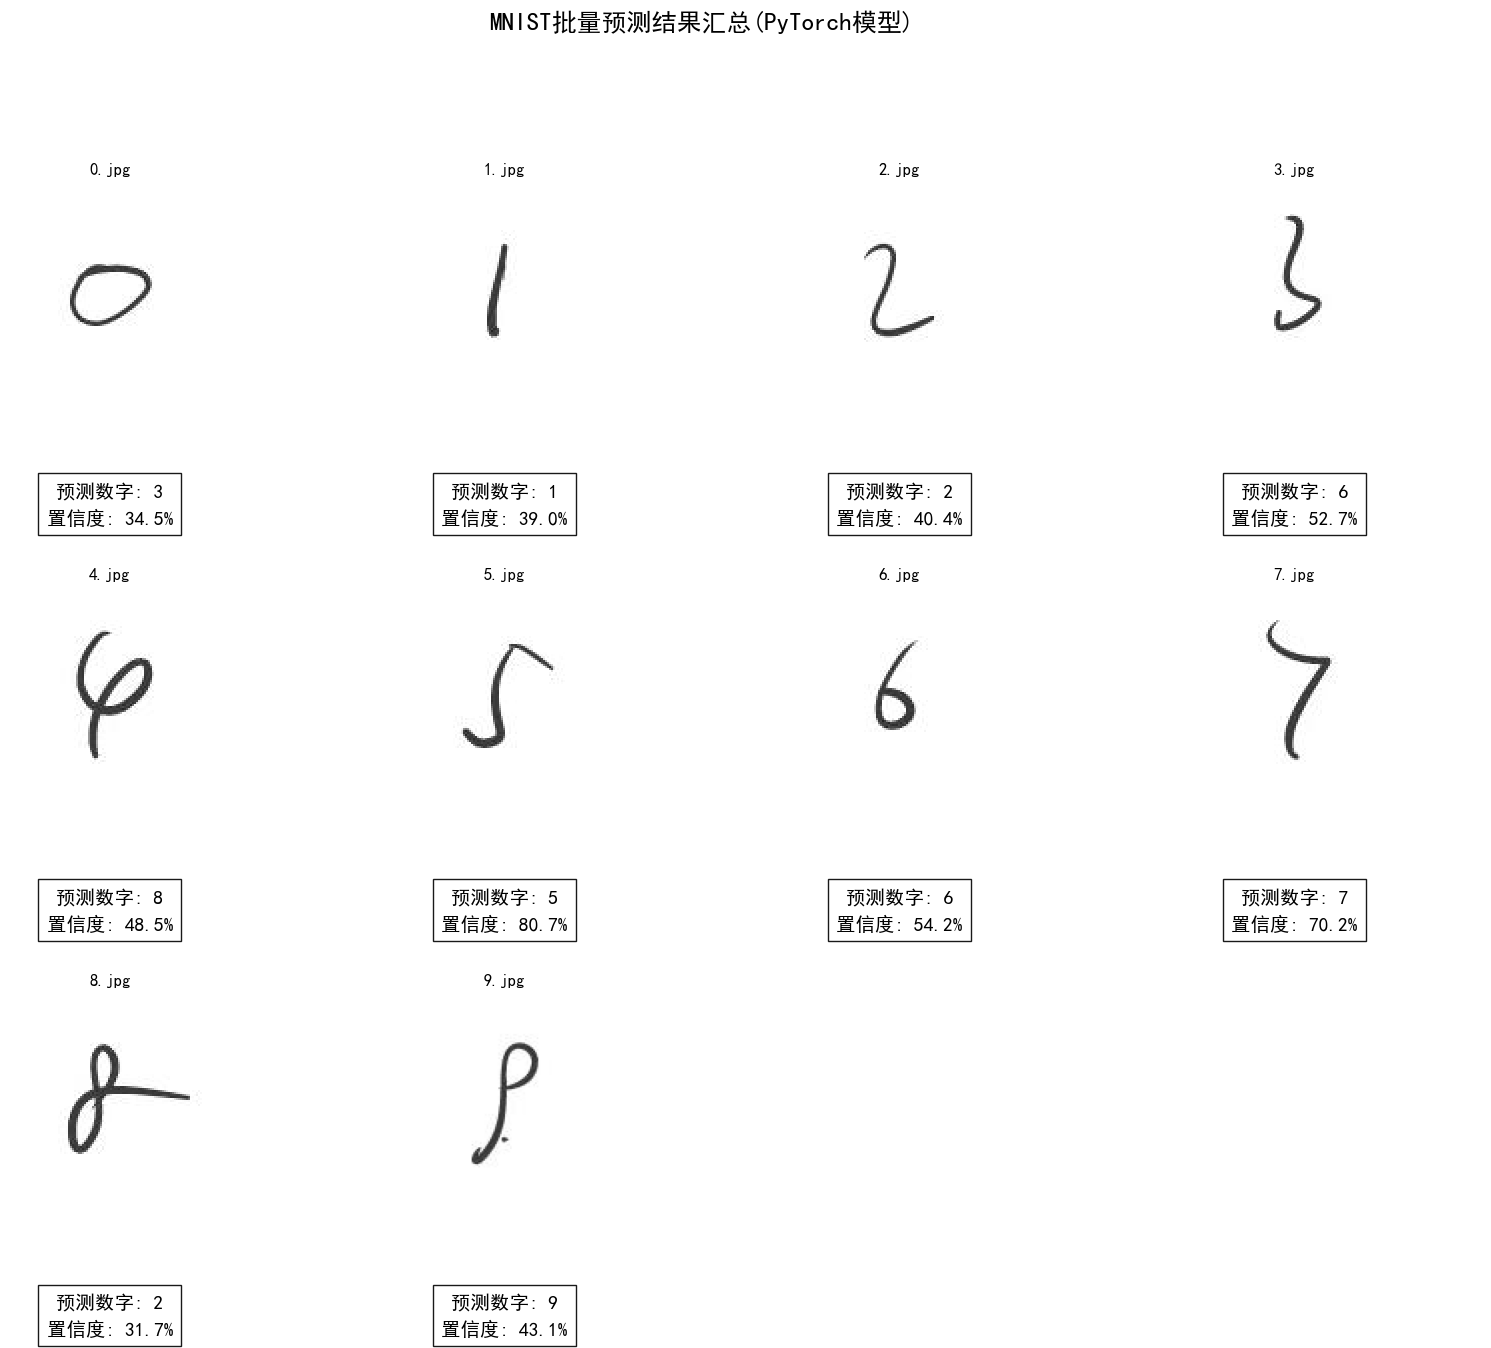

In [34]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.font_manager as fm

# ---------------------- PyTorch模型定义（与训练时一致） ----------------------
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 输入(1,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # 输出(32,14,14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 输入(32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2)   # 输出(64,7,7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 展平为(批量, 64*7*7)
        return self.classifier(x)

# ---------------------- 核心功能函数 ----------------------
def preprocess_image(image_path, target_size=(28, 28)):
    """
    带颜色反转的图像预处理（白底黑字转黑底白字）
    返回: 形状为[1,1,28,28]的输入张量（批次x通道x高x宽）
    """
    try:
        img = Image.open(image_path).convert('L')  # 转换为灰度图（像素值0-255，白色为255，黑色为0）
        img = img.resize(target_size, Image.Resampling.LANCZOS)  # 调整尺寸
        
        # 颜色反转核心逻辑：白底黑字（背景255/数字0）转黑底白字（背景0/数字255）
        img_array = np.array(img, dtype=np.float32)  # 转换为numpy数组（值范围0-255）
        img_array = 255.0 - img_array  # 颜色反转（关键步骤）
        img_array = img_array / 255.0  # 归一化到[0,1]（此时数字区域为1，背景为0，符合MNIST格式）
        
        img_tensor = transforms.ToTensor()(img_array)  # 转换为张量（形状[1,28,28]）
        return img_tensor.unsqueeze(0)  # 添加批次维度 → 形状[1,1,28,28]
    except Exception as e:
        raise RuntimeError(f"预处理失败（{image_path}）: {str(e)}")

def load_pytorch_model(model_path='mnist_classifier.pth'):
    """加载PyTorch模型（自动检测CPU/GPU）"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MNISTClassifier().to(device)
    try:
        state_dict = torch.load(model_path, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()  # 切换到评估模式
        print(f"模型加载成功（设备: {device}）")
        return model, device
    except Exception as e:
        raise RuntimeError(f"模型加载失败: {str(e)}")

def predict_image(image_path, model, device):
    """单张图片预测（返回带图片路径的结果字典）"""
    try:
        input_tensor = preprocess_image(image_path).to(device)  # 预处理并移动到设备
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.softmax(outputs, dim=1)  # 转换为概率分布
            pred_label = torch.argmax(probs).item()  # 获取最大概率的标签
            confidence = probs.max().item()  # 获取置信度
        return {
            'image_path': image_path,
            'pred_label': pred_label,
            'confidence': confidence
        }
    except Exception as e:
        raise RuntimeError(f"预测失败（{image_path}）: {str(e)}")

def batch_predict(image_folder, model, device):
    """批量预测文件夹中的所有图片"""
    image_paths = glob(os.path.join(image_folder, '*.png')) + \
                  glob(os.path.join(image_folder, '*.jpg')) + \
                  glob(os.path.join(image_folder, '*.jpeg'))
    
    results = []
    for img_path in image_paths:
        try:
            results.append(predict_image(img_path, model, device))
            print(f"已处理: {os.path.basename(img_path)} → 预测: {results[-1]['pred_label']}（置信度: {results[-1]['confidence']*100:.1f}%）")
        except Exception as e:
            print(f"警告：处理 {img_path} 时出错: {str(e)}，已跳过")
    return results

def create_summary_plot(results, output_path='prediction_summary.png', cols=4):
    """优化字体显示和布局的批量预测结果汇总图"""
    # 中文字体配置（与之前一致）
    font_paths = fm.findSystemFonts()
    chinese_font = None
    preferred_fonts = ['SimHei', 'PingFang SC', 'WenQuanYi Zen Hei']
    for font in preferred_fonts:
        if any(font in path for path in font_paths):
            chinese_font = fm.FontProperties(fname=[p for p in font_paths if font in p][0])
            break
    if not chinese_font:
        print("警告：未找到系统中文字体，可能导致中文显示异常")
        chinese_font = fm.FontProperties()

    rows = (len(results) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4.5))
    fig.suptitle('MNIST批量预测结果汇总(PyTorch模型)', 
                 fontproperties=chinese_font, 
                 fontsize=18, y=1.02)

    for idx, result in enumerate(results):
        row, col = idx // cols, idx % cols
        ax = axes[row, col] if rows > 1 else axes[col] if cols > 1 else axes

        # 显示原始图片（注意：此处显示的是反转后的效果，若需显示原图需注释反转逻辑）
        img = Image.open(result['image_path'])
        ax.imshow(img, cmap='gray')  # 以灰度图显示
        ax.axis('off')

        # 生成预测结果文本
        pred_text = f"预测数字: {result['pred_label']}\n置信度: {result['confidence']*100:.1f}%"

        # 绘制文本（调整位置和样式）
        ax.text(0.5, -0.5, pred_text,
                transform=ax.transAxes,
                ha='center', va='top',
                bbox=dict(facecolor='white', alpha=0.9, pad=6),
                fontproperties=chinese_font,
                fontsize=14,
                linespacing=1.5)

        # 设置子图标题（原始文件名）
        ax.set_title(os.path.basename(result['image_path']), 
                     fontproperties=chinese_font, 
                     fontsize=12)

    # 隐藏多余子图并调整布局
    for idx in range(len(results), rows*cols):
        row, col = idx // cols, idx % cols
        axes[row, col].axis('off')
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4, wspace=0.2)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f'汇总图已保存至: {output_path}')

# ---------------------- 主程序 ----------------------
if __name__ == '__main__':
    IMAGE_FOLDER = '手写数字图像/3'   # 输入图片文件夹路径
    MODEL_PATH = '1/mnist_classifier.pth'      # 训练好的PyTorch模型路径
    OUTPUT_PATH = '1/r3_torch_5.png'     # 汇总图保存路径

    try:
        model, device = load_pytorch_model(MODEL_PATH)
    except Exception as e:
        print(f"错误: {e}")
        exit()

    print(f'\n正在处理文件夹: {IMAGE_FOLDER}（已启用颜色反转）')
    results = batch_predict(IMAGE_FOLDER, model, device)
    print(f'完成 {len(results)} 张图片的预测')

    if results:
        create_summary_plot(results, OUTPUT_PATH)
    else:
        print('警告：未找到可处理的图片文件')